In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path
import yaml
import re

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Mon Oct 13 09:51:13 PDT 2025
lutzes
/mnt/share/homes/lutzes/vivarium_research_alzheimers/verification_and_validation


# V&V list

# Find data

In [2]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
# Results directory containing model 6 results for all locations
!ls -halt results/model6.0/model_spec/2025_10_03_12_33_34/results

total 232M
drwxrwsr-x 5 sbachmei IHME-Simulationscience 4.5K Oct  3 13:06 ..
drwxrwsr-x 2 sbachmei IHME-Simulationscience 4.5K Oct  3 13:06 .
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  16M Oct  3 13:06 baseline_test_counts_among_eligible.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 3.8M Oct  3 13:05 bbbm_test_eligibility_counts.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 101M Oct  3 13:05 ylds.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  55M Oct  3 13:05 ylls.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 9.1M Oct  3 13:05 deaths.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 6.0M Oct  3 13:05 new_simulants.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  12M Oct  3 13:05 transition_count_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience 2.1M Oct  3 13:05 bbbm_test_counts.parquet
-rw-rw-r-- 1 sbachmei IHME-Simulationscience  29M Oct  3 13:04 person_time_alzheimers_disease_and_other_dementias.parquet

In [4]:
!ls results/model6.0/model_spec/2025_10_03_12_33_34/

__pycache__		   keyspace.yaml	     requirements.txt
branches.yaml		   logs			     results
finished_sim_metadata.csv  model_specification.yaml  settings.py


In [5]:
locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations}| {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# Select a subset of locations to draw plots for
locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

model_number = '6.0' # Artifacts are stored here
run_subdirectories = [
    'results/model6.1/united_states_of_america/2025_10_08_10_41_07/',
]
run_dirs = [project_dir + run_subdir for run_subdir in run_subdirectories]
results_dirs = [run_dir + 'results/' for run_dir in run_dirs]

# Option 1: One artifact per location
location_to_results_dir = {
    loc: path for loc, path in zip(locations, results_dirs)}

# # Option 2: All locations in one artifact
# location_to_results_dir = {'all': results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = [f'artifacts/model{model_number}/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
artifact_path_to_location = {path: loc for loc, path in location_to_artifact_path.items()}
# artifact_path_to_location = {project_dir + subpath: loc for subpath, loc in zip(artifact_subpaths, locations)}
artifact_path_to_location

{'/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/united_states_of_america.hdf': 'United States of America',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/brazil.hdf': 'Brazil',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/china.hdf': 'China',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/germany.hdf': 'Germany',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/israel.hdf': 'Israel',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/japan.hdf': 'Japan',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/spain.hdf': 'Spain',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/sweden.hdf': 'Sweden',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/taiwan_(province_of

In [6]:
artifact_path_to_location

{'/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/united_states_of_america.hdf': 'United States of America',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/brazil.hdf': 'Brazil',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/china.hdf': 'China',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/germany.hdf': 'Germany',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/israel.hdf': 'Israel',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/japan.hdf': 'Japan',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/spain.hdf': 'Spain',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/sweden.hdf': 'Sweden',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model6.0/taiwan_(province_of

# Get list of draws and draw columns from `keyspace.yaml`, and reduce to a subset of draws to save memory and time

In [7]:
with open(run_dirs[0] + 'keyspace.yaml', 'r') as keyspace_file:
    keyspace = yaml.safe_load(keyspace_file)
draws = keyspace['input_draw']
print(draws)

[457, 169, 323, 392, 346, 480, 258, 446, 356, 273, 158, 24, 265, 317, 177, 199, 2, 13, 46, 89, 41, 113, 262, 460, 499]


In [8]:
# I ended up never actually using this -- I just used all the draws
draws = sorted(draws[:10]) # reduce to a subset of draws to save memory, and sort
draw_cols = [f'draw_{i}' for i in draws]
print(draw_cols)

['draw_169', 'draw_258', 'draw_273', 'draw_323', 'draw_346', 'draw_356', 'draw_392', 'draw_446', 'draw_457', 'draw_480']


# Load one artifact and define age bins

In [9]:
usa_artifact_path = location_to_artifact_path['United States of America']
usa_art = Artifact(usa_artifact_path)
print(usa_art.load('metadata.locations'))
print(usa_art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet



In [10]:
# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = usa_art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54
10,16,55 to 59,55.0,60.0,55_to_59
11,17,60 to 64,60.0,65.0,60_to_64
12,18,65 to 69,65.0,70.0,65_to_69
13,19,70 to 74,70.0,75.0,70_to_74


In [11]:
age_bins.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19 entries, (6, '5 to 9', 5.0, 10.0) to (235, '95 plus', 95.0, 125.0)
Empty DataFrame


# Define functions to load and merge Artifact data from all locations, and to summarize Artifact data for plotting

In [11]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

# Load CSF and PET testing rates

In [12]:
# NOTE: Dropping level 1 of index because it is meaningless, containing
# all 0s: 
# https://github.com/ihmeuw/vivarium_csu_alzheimers/blob/7674a25da52e8b9ee23c0184a2e65c6f53aac335/src/vivarium_csu_alzheimers/data/loader.py#L487-L489
csf_rates = load_artifact_data('testing_rates.csf').droplevel(1)
pet_rates = load_artifact_data('testing_rates.pet').droplevel(1)
existing_test_rates = (
    pd.concat(
        {'csf': csf_rates, 'pet': pet_rates}, names=['test_type', 'location'])
    .rename_axis(columns='input_draw')
)
existing_test_rates

input_draw                              draw_0    draw_1    draw_2    draw_3  \
test_type location                                                             
csf       United States of America    0.086170  0.140511  0.102449  0.092320   
          Brazil                      0.105865  0.173411  0.126100  0.113509   
          China                       0.035023  0.057369  0.041717  0.037552   
          Germany                     0.148848  0.243818  0.177298  0.159596   
          Israel                      0.105865  0.173411  0.126100  0.113509   
          Japan                       0.105865  0.173411  0.126100  0.113509   
          Spain                       0.195811  0.320745  0.233237  0.209950   
          Sweden                      0.322372  0.528056  0.383988  0.345649   
          Taiwan (Province of China)  0.105865  0.173411  0.126100  0.113509   
          United Kingdom              0.075618  0.123865  0.090071  0.081078   
pet       United States of America    0.172089  0.196148  0.165458  0.088834   
          Brazil                      0.170942  0.194840  0.164355  0.088241   
          China                       0.069983  0.079767  0.067286  0.036126   
          Germany                     0.183562  0.209225  0.176489  0.094756   
          Israel                      0.170942  0.194840  0.164355  0.088241   
          Japan                       0.170942  0.194840  0.164355  0.088241   
          Spain                       0.297141  0.338682  0.285691  0.153386   
          Sweden                      0.051627  0.058844  0.049637  0.026650   
          Taiwan (Province of China)  0.170942  0.194840  0.164355  0.088241   
          United Kingdom              0.122757  0.139919  0.118027  0.063368   

input_draw                              draw_4    draw_5    draw_6    draw_7  \
test_type location                                                             
csf       United States of America    0.126445  0.062653  0.118921  0.087192   
          Brazil                      0.155928  0.076634  0.146575  0.107136   
          China                       0.051585  0.025353  0.048491  0.035443   
          Germany                     0.219236  0.107748  0.206087  0.150634   
          Israel                      0.155928  0.076634  0.146575  0.107136   
          Japan                       0.155928  0.076634  0.146575  0.107136   
          Spain                       0.288407  0.141744  0.271109  0.198161   
          Sweden                      0.474817  0.233359  0.446338  0.326240   
          Taiwan (Province of China)  0.155928  0.076634  0.146575  0.107136   
          United Kingdom              0.111377  0.054738  0.104697  0.076526   
pet       United States of America    0.164784  0.180419  0.178008  0.223862   
          Brazil                      0.163686  0.179216  0.176821  0.222370   
          China                       0.067012  0.073370  0.072390  0.091037   
          Germany                     0.175770  0.192447  0.189875  0.238786   
          Israel                      0.163686  0.179216  0.176821  0.222370   
          Japan                       0.163686  0.179216  0.176821  0.222370   
          Spain                       0.284528  0.311524  0.307361  0.386535   
          Sweden                      0.049435  0.054126  0.053402  0.067159   
          Taiwan (Province of China)  0.163686  0.179216  0.176821  0.222370   
          United Kingdom              0.117546  0.128699  0.126979  0.159688   

input_draw                              draw_8    draw_9  ...  draw_490  \
test_type location                                        ...             
csf       United States of America    0.096971  0.095522  ...  0.131668   
          Brazil                      0.119291  0.117490  ...  0.162419   
          China                       0.039465  0.038869  ...  0.053733   
          Germany                     0.167726  0.165193  ...  0.228364   
          Israel            

In [13]:
existing_test_rates.stack().rename('value').to_frame()

value
test_type location                 input_draw          
csf       United States of America draw_0      0.086170
                                   draw_1      0.140511
                                   draw_2      0.102449
                                   draw_3      0.092320
                                   draw_4      0.126445
...                                                 ...
pet       United Kingdom           draw_495    0.143989
                                   draw_496    0.129093
                                   draw_497    0.117380
                                   draw_498    0.107381
                                   draw_499    0.068556

[10000 rows x 1 columns]

# Create VPHOperator object to perform operations on simulation output

In [14]:
ops = VPHOperator()
ops.index_cols.append('location')
ops.index_cols

['input_draw', 'scenario', 'location']

In [15]:
# Oh good, the VPHOperator object must have made its own copy of the index
# columns in the module, even though the code doesn't explicitly specify
# this -- I was worried that 'location' would have gotten added to the
# module's INDEX_COLUMNS constant
vh.vph_output.operations.INDEX_COLUMNS

['input_draw', 'scenario']

# Define a filter

In [116]:
# draw_filter = ('input_draw', in, draws)

# Define function to load simulation output, and load baseline test counts

In [16]:
def load_sim_output(
        measure,
        results_dict=location_to_results_dir,
        artifact_path_to_location=artifact_path_to_location,
        drop_superfluous_cols=True, # drop redundant or empty columns
        force_categorical=True,
        aggregate_seeds=True,
        raw=False, # Overrides other parameters if True
        **kwargs, # keyword args to pass to .read_parquet
    ):
    """Load simulation output from .parquet files for all locations,
    optionally reducing the size of the data when possible. Returns
    concatenated outputs with a 'location' column added.
    """
    if raw:
        drop_superfluous_cols = False
        force_categorical = False
        aggregate_seeds = False

    dfs = []
    for location, directory in results_dict.items():
        df = pd.read_parquet(Path(directory) / f'{measure}.parquet', **kwargs)
        if drop_superfluous_cols:
            # Drop redundant columns
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
            # Drop empty columns
            for col in df:
                if df[col].isna().all():
                    df.drop(columns=col, inplace=True)
        if force_categorical:
            convert_to_categorical(df, inplace=True)
        if aggregate_seeds:
            # Use default index and value columns when aggregating
            df = vh.vph_output.operations.marginalize(df, 'random_seed')
        if location == 'all':
            if 'artifact_path' in df:
                df['location'] = df['artifact_path'].map(artifact_path_to_location)
        else:
            df['location'] = location
        dfs.append(df)
    df = pd.concat(dfs)
    return df

# TODO: Consider making certain columns ordered Categoricals
def convert_to_categorical(df, inplace=False):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if not inplace:
        df = df.copy()
    for col in df:
        if df[col].dtype not in ('float', 'category'):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

# NOTE: Differs from version in Vivarium Helpers in that here,
# dropna=False
def marginalize(
    df:pd.DataFrame,
    marginalized_cols,
    value_cols=None,
    reset_index=True,
    func='sum',
    args=(), # Positional args to pass to func in DataFrameGroupBy.agg
    **kwargs, # Keywords to pass to DataFrameGroupBy.agg
)->pd.DataFrame:
    if value_cols is None:
        value_cols = vh.vph_output.operations.value_col
    marginalized_cols = vh.utils._ensure_iterable(marginalized_cols)
    value_cols = vh.utils._ensure_iterable(value_cols)
    # Move Index levels into columns to enable passing index
    # level names as well as column names to marginalize
    df = vh.utils._ensure_columns_not_levels(df, marginalized_cols)
    groupby_cols = df.columns.difference(
        # must convert Index to list for groupby to work properly
        [*marginalized_cols, *value_cols]).to_list()
    aggregated_data = df.groupby(
        # observed=True needed for Categorical data
        groupby_cols, as_index=(not reset_index),
        observed=True, dropna=False,
    )[value_cols].agg(func, *args, **kwargs)
    return aggregated_data

def summarize_sim_data(df, age_dictionary=age_dictionary):
    """Summarize simulation data for plotting."""
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

In [17]:


# On the first attempt, this resulted in an empty DataFrame. Using
# raw=True, I determined that the .groupby was failing because of NaNs
# in the sub_entity column, since dropna=True by default.
existing_tests = load_sim_output(
    'counts_baseline_tests_among_eligible',
    # raw=True,
    )
existing_tests

,age_group,artifact_path,entity,entity_type,event_year,input_draw,measure,scenario,sex,testing_state,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,not_tested,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,csf,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,pet,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Female,bbbm,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2025,356,counts_baseline_tests_among_eligible,baseline,Male,not_tested,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...
455995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Female,bbbm,0.0,United States of America
455996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Male,not_tested,44.0,United States of America
455997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Male,csf,9.0,United States of America
455998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,baseline_testing,testing,2100,317,counts_baseline_tests_among_eligible,bbbm_testing,Male,pet,12.0,United States of America


In [18]:
# Check memory usage -- loading it raw, it took up 2.1 GB
existing_tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456000 entries, 0 to 455999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   age_group      456000 non-null  category
 1   artifact_path  456000 non-null  category
 2   entity         456000 non-null  category
 3   entity_type    456000 non-null  category
 4   event_year     456000 non-null  category
 5   input_draw     456000 non-null  category
 6   measure        456000 non-null  category
 7   scenario       456000 non-null  category
 8   sex            456000 non-null  category
 9   testing_state  456000 non-null  category
 10  value          456000 non-null  float64 
 11  location       456000 non-null  object  
dtypes: category(10), float64(1), object(1)
memory usage: 11.3+ MB


In [20]:
# See if there is only one measure, or more
existing_tests.measure.unique()

['baseline_test_counts_among_eligible']
Categories (1, object): ['baseline_test_counts_among_eligible']

In [21]:
# Check whether all values are integers -- yes
(existing_tests.value % 1).unique()

array([0.])

## Finding Averted CSF and PET Test Counts

In [19]:
bbbm_test_counts = load_sim_output(
    'counts_bbbm_tests',
)
bbbm_test_counts

,age_group,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,first,Female,0.0,United States of America
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,first,Male,0.0,United States of America
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,second,Female,0.0,United States of America
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,baseline,second,Male,0.0,United States of America
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,counts_bbbm_tests,bbbm_testing,first,Female,0.0,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
683995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,baseline,second,Male,0.0,United States of America
683996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,bbbm_testing,first,Female,0.0,United States of America
683997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,bbbm_testing,first,Male,0.0,United States of America
683998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,counts_bbbm_tests,bbbm_testing,second,Female,0.0,United States of America


In [20]:
bbbm_testing = (
    bbbm_test_counts
    .loc[(bbbm_test_counts.bbbm_test_results == 'positive') & (bbbm_test_counts.scenario == 'bbbm_testing')]
    .groupby(['location', 'age_group', 'sex', 'input_draw','scenario','event_year']).sum()['value'].reset_index()
    .groupby(['location', 'age_group', 'sex', 'scenario','event_year']).mean()['value']
    .reset_index()
    .rename(columns={'event_year': 'current_year'})
    # .loc[existing_tests.testing_state.isin(['csf','pet'])]
)
bbbm_testing

/tmp/ipykernel_3674237/905063326.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby(['location', 'age_group', 'sex', 'input_draw','scenario','event_year']).sum()['value'].reset_index()
/tmp/ipykernel_3674237/905063326.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby(['location', 'age_group', 'sex', 'scenario','event_year']).mean()['value']


,location,age_group,sex,scenario,current_year,value
0,United States of America,25_to_29,Female,baseline,2025,0.0
1,United States of America,25_to_29,Female,baseline,2026,0.0
2,United States of America,25_to_29,Female,baseline,2027,0.0
3,United States of America,25_to_29,Female,baseline,2028,0.0
4,United States of America,25_to_29,Female,baseline,2029,0.0
...,...,...,...,...,...,...
4555,United States of America,95_plus,Male,bbbm_testing,2096,0.0
4556,United States of America,95_plus,Male,bbbm_testing,2097,0.0
4557,United States of America,95_plus,Male,bbbm_testing,2098,0.0
4558,United States of America,95_plus,Male,bbbm_testing,2099,0.0


In [21]:
# In the dataframe existing_tests, I want to subtract all values with scenario=bbbm_testing from those scenario=baseline to get the averted tests
averted_tests = (
    existing_tests
    .groupby(['location', 'age_group', 'sex', 'input_draw', 'testing_state','scenario','event_year']).sum()['value'].reset_index()
    .groupby(['location', 'age_group', 'sex', 'testing_state','scenario','event_year']).mean()['value']
    .unstack('scenario')
    .assign(averted=lambda df: df['baseline'] - df['bbbm_testing'])
    .reset_index()
    .drop(columns=['baseline', 'bbbm_testing'])
    .rename(columns={'averted': 'value', 'event_year': 'current_year'})
    # .loc[existing_tests.testing_state.isin(['csf','pet'])]
)
#averted_tests

/tmp/ipykernel_3674237/4027700383.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby(['location', 'age_group', 'sex', 'input_draw', 'testing_state','scenario','event_year']).sum()['value'].reset_index()
/tmp/ipykernel_3674237/4027700383.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .groupby(['location', 'age_group', 'sex', 'testing_state','scenario','event_year']).mean()['value']


In [22]:
locations = [
            'united_states_of_america',
             'brazil',
             'china',
             'germany',
             'israel',
             'japan',
             'spain',
             'sweden',
             'taiwan_(province_of_china)',
             'united_kingdom',
            ]

artifact_dirs = ['artifacts/model6.0/' + x + '.hdf' for x in locations]
artifact_dirs

['artifacts/model6.0/united_states_of_america.hdf',
 'artifacts/model6.0/brazil.hdf',
 'artifacts/model6.0/china.hdf',
 'artifacts/model6.0/germany.hdf',
 'artifacts/model6.0/israel.hdf',
 'artifacts/model6.0/japan.hdf',
 'artifacts/model6.0/spain.hdf',
 'artifacts/model6.0/sweden.hdf',
 'artifacts/model6.0/taiwan_(province_of_china).hdf',
 'artifacts/model6.0/united_kingdom.hdf']

In [23]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    # temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2023"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    ratio = 100_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'current_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.018283685923580616
0.04583767883804687
0.005042604291586587
0.039606953062466733
1.758450962578899
0.02577213823808569
0.13774040936958382
0.5625178546183628
0.3650829538988746
0.08726914922159383


In [24]:
averted_tests = averted_tests.merge(scale[['location','sex','age_group','ratio']], on=['location','sex','age_group'])
#Convert averted_tests.current year to a scalar value instead of a categorical value
averted_tests['current_year'] = averted_tests['current_year'].astype(int)
averted_tests['averted_tests'] = averted_tests['value'] / averted_tests['ratio']
averted_tests = averted_tests.groupby(['location','current_year','testing_state','sex','age_group']).mean()['averted_tests'].reset_index()
averted_tests.tail()

,location,current_year,testing_state,sex,age_group,averted_tests
9115,United States of America,2100,pet,Male,75_to_79,2953.452615
9116,United States of America,2100,pet,Male,80_to_84,2809.061598
9117,United States of America,2100,pet,Male,85_to_89,1198.882987
9118,United States of America,2100,pet,Male,90_to_94,411.295623
9119,United States of America,2100,pet,Male,95_plus,85.321964


In [25]:
bbbm_testing = bbbm_testing.merge(scale[['location','sex','age_group','ratio']], on=['location','sex','age_group'])
#Convert averted_tests.current year to a scalar value instead of a categorical value
bbbm_testing['current_year'] = bbbm_testing['current_year'].astype(int)
bbbm_testing['bbbm_tests'] = bbbm_testing['value'] / bbbm_testing['ratio']
bbbm_testing = bbbm_testing.groupby(['location','current_year','sex','age_group']).mean()['bbbm_tests'].reset_index()
bbbm_testing.tail()

/tmp/ipykernel_3674237/439783186.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bbbm_testing = bbbm_testing.groupby(['location','current_year','sex','age_group']).mean()['bbbm_tests'].reset_index()


,location,current_year,sex,age_group,bbbm_tests
2275,United States of America,2100,Male,75_to_79,941.823223
2276,United States of America,2100,Male,80_to_84,0.000000
2277,United States of America,2100,Male,85_to_89,0.000000
2278,United States of America,2100,Male,90_to_94,0.000000
2279,United States of America,2100,Male,95_plus,0.000000


In [26]:
pt_ever_eligible_bbbm = load_sim_output(
    'person_time_ever_eligible_for_bbbm_testing'
)
pt_ever_eligible_bbbm

,age_group,alzheimers_disease_and_other_dementias,artifact_path,bbbm_test_results,entity,entity_type,event_year,input_draw,measure,scenario,semester,sex,value,location
0,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,first,Female,0.000000,United States of America
1,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,first,Male,0.000000,United States of America
2,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,second,Female,0.000000,United States of America
3,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,baseline,second,Male,0.000000,United States of America
4,25_to_29,alzheimers_blood_based_biomarker_state,/mnt/team/simulation_science/pub/models/vivari...,not_tested,bbbm_testing,testing,2025,356,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Female,0.000000,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2051995,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,baseline,second,Male,0.000000,United States of America
2051996,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Female,10.464066,United States of America
2051997,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,first,Male,5.481177,United States of America
2051998,95_plus,alzheimers_disease_state,/mnt/team/simulation_science/pub/models/vivari...,negative,bbbm_testing,testing,2100,317,person_time_ever_eligible_for_bbbm_testing,bbbm_testing,second,Female,11.958932,United States of America


In [27]:
ever_tested_over_ever_eligible = ops.ratio(
    pt_ever_eligible_bbbm.query(
        "bbbm_test_results != 'not_tested' and alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'"),
    pt_ever_eligible_bbbm.query("alzheimers_disease_and_other_dementias == 'alzheimers_blood_based_biomarker_state'"),
    strata=['event_year', 'age_group'],
).query("scenario == 'bbbm_testing'")
ever_tested_over_ever_eligible

,event_year,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
1,2025,25_to_29,356,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
3,2025,25_to_29,346,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
5,2025,25_to_29,113,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
7,2025,25_to_29,273,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
9,2025,25_to_29,499,bbbm_testing,United States of America,NaN,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
...,...,...,...,...,...,...,...,...,...
56991,2100,95_plus,323,bbbm_testing,United States of America,0.665944,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
56993,2100,95_plus,2,bbbm_testing,United States of America,0.606583,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
56995,2100,95_plus,41,bbbm_testing,United States of America,0.619485,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1
56997,2100,95_plus,24,bbbm_testing,United States of America,0.615681,person_time_ever_eligible_for_bbbm_testing,person_time_ever_eligible_for_bbbm_testing,1


In [28]:
test_percent = ever_tested_over_ever_eligible.query("age_group in ['60_to_64', '65_to_69', '70_to_74', '75_to_79']")
test_percent['current_year'] = test_percent['event_year'].astype(int)
test_percent = test_percent.groupby(['location','current_year']).mean()['value'].reset_index()
test_percent


/tmp/ipykernel_3674237/1427919704.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_percent = test_percent.groupby(['location','current_year']).mean()['value'].reset_index()


,location,current_year,value
0,United States of America,2025,0.000000
1,United States of America,2026,0.000000
2,United States of America,2027,0.000000
3,United States of America,2028,0.000000
4,United States of America,2029,0.000000
...,...,...,...
71,United States of America,2096,0.600509
72,United States of America,2097,0.600733
73,United States of America,2098,0.600349
74,United States of America,2099,0.600311


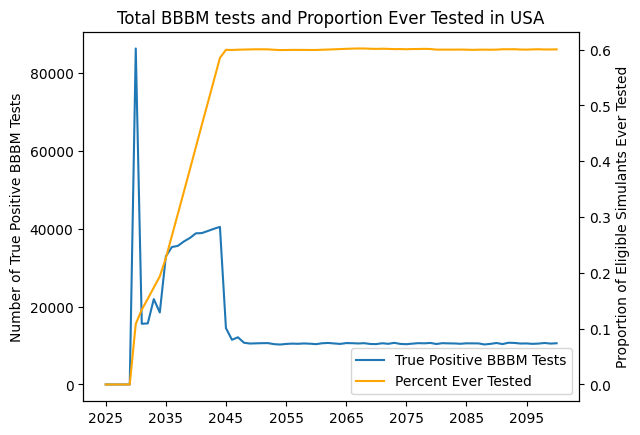

<Figure size 640x480 with 0 Axes>

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for location in bbbm_testing.location.unique():
    figsize = (10, 12)
    
    ax1 = plt.gca()
    plot_data1 = bbbm_testing.groupby(['location','current_year']).sum()['bbbm_tests'].reset_index()
    plot_data1 = plot_data1.loc[(plot_data1.location == location)]
    ax1.plot(plot_data1['current_year'],plot_data1['bbbm_tests'], label='True Positive BBBM Tests')
    ax1.set_ylabel('Number of True Positive BBBM Tests')
    # ax1.legend(loc='right')

# I want this plot on a different scale of y axis 
    plot_data2 = test_percent.loc[(test_percent.location == location)]
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
    ax2.plot(plot_data2['current_year'], plot_data2['value'], color='orange', label='Percent Ever Tested')
    ax2.set_ylabel('Proportion of Eligible Simulants Ever Tested')
    # ax2.legend(loc='best')

    plt.title(f'Total BBBM tests and Proportion Ever Tested in {location_to_short_name[location]}')
    plt.xlabel('Year')
    plt.xticks(np.arange(2025, 2101, 10))
    #plt.ticklabel_format(style='plain')
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')
    plt.figure()

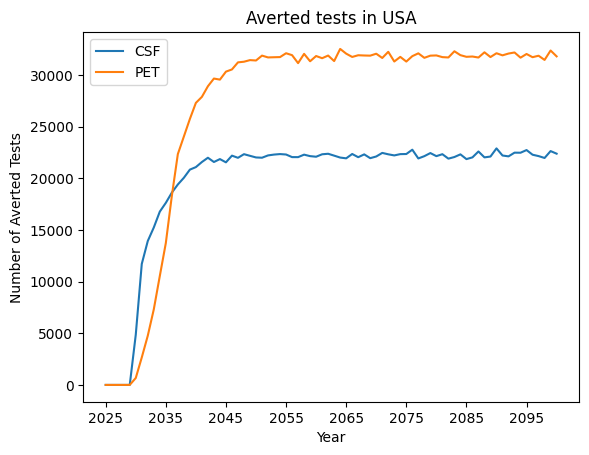

<Figure size 640x480 with 0 Axes>

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for location in averted_tests.location.unique():
    for test in ['csf','pet']:
        figsize = (10, 12)
        plot_data = averted_tests.groupby(['location','current_year','testing_state']).sum()['averted_tests'].reset_index()
        plot_data = plot_data.loc[(plot_data.location == location) & (plot_data.testing_state == test)]
        plt.plot(plot_data['current_year'],plot_data['averted_tests'], label=test.upper())
        plt.title(f'Averted tests in {location_to_short_name[location]}')
        plt.xlabel('Year')
        plt.ylabel('Number of Averted Tests')
        plt.xticks(np.arange(2025, 2101, 10))
        plt.legend()
        plt.ticklabel_format(style='plain')
    plt.figure()

# Plot test CSF/PET test rates

Let's make a grid of plots with one column for each scenario and one row
for each country. In each axes, plot testing rate over time, with one
line for each of the four testing states, and plot Artifact testing
rates in same color but different line style.

In [22]:
def plot_over_time_by_column(df, colname, ylabel='', title='', uncertainty=True, ax=None):
    """Plot mean value vs. year for each value in the column `colname`,
    optionally with (lower, upper) uncertainty band.
    """
    if ax is None:
        ax = plt.gca()
#     df = cs.age_to_ordered_categorical(df) # Order the age groups chronologically
    # df = csr.to_ordered_categoricals(df)
    
    # agg = df.groupby([colname, 'event_year'])['value'].describe(percentiles=[.025, .975])
    # agg = vh.vph_output.operations.stratify(df, [colname, 'event_year'], func=['mean', lower, upper])['value']
    agg = df.groupby([colname, 'event_year'], observed=True)['value'].agg(['mean', lower, upper])
    col_vals = agg.index.unique(colname)
    for col_val in col_vals:
        values = agg.xs(col_val)
        years = values.index
        ax.plot(years, values['mean'], label=f"{colname}={col_val}")
        if uncertainty:
            # ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
            ax.fill_between(years, values['lower'], values['upper'], alpha=.1)

    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

def plot_over_time_by_column_for_row_x_1(
        df, colname, row_variable, ylabel='', suptitle='', uncertainty=True,
        axes_width=12, axes_height=6,
    ):
    """Draw a nx1 figure with rows indexed by location, calling plot_over_time_by_column()
    for each subplot.
    """
    # Get ordered list of locations in the dataframe
    # df = csr.to_ordered_categoricals(df)
    df = convert_to_categorical(df)
    row_values = df[row_variable].unique().sort_values()
    fig, axs = plt.subplots(
        len(row_values), 1,
        figsize=(axes_width, axes_height * len(row_values)))
    for row_num, row_value in enumerate(row_values):
        plot_over_time_by_column(
            df.query(f"{row_variable}==@row_value"),
            colname,
            ylabel,
            f"{row_variable}={row_value}",
            uncertainty,
            ax=axs[row_num],
        )
    fig.suptitle(suptitle, fontsize=18)
    fig.tight_layout()
    return fig

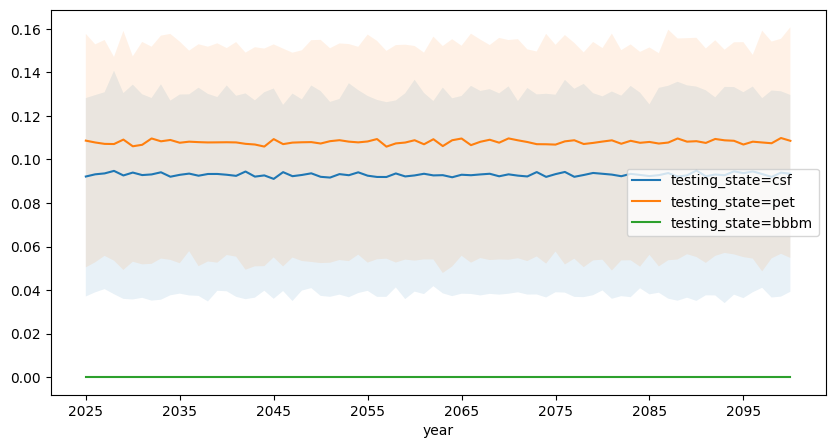

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
plot_over_time_by_column(
    sim_test_rates
    .query("location == 'United Kingdom' and scenario == 'baseline' and testing_state != 'not_tested'"),
    'testing_state')
ax.set_xticks(ax.get_xticks()[::10])
# ax.tick_params(rotation=90)
plt.show()

# Plot existing test rates in baseline for each country

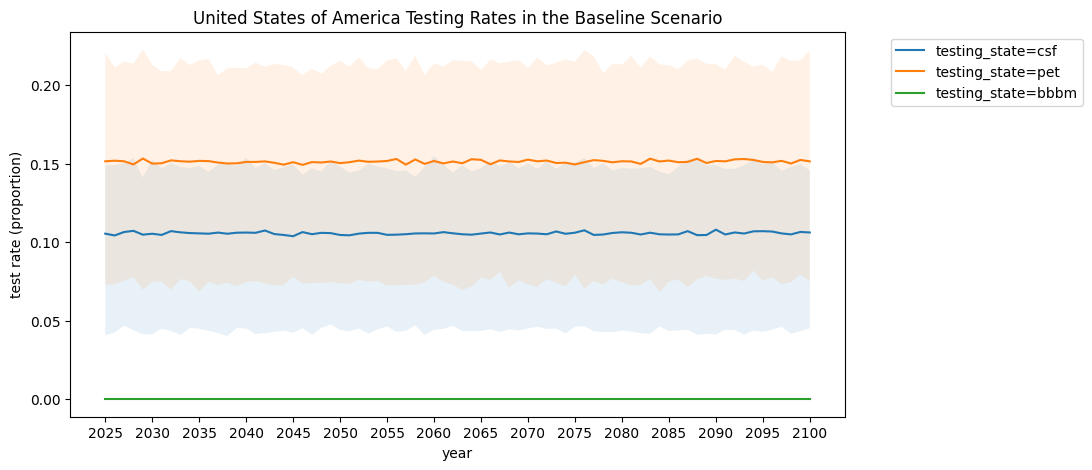

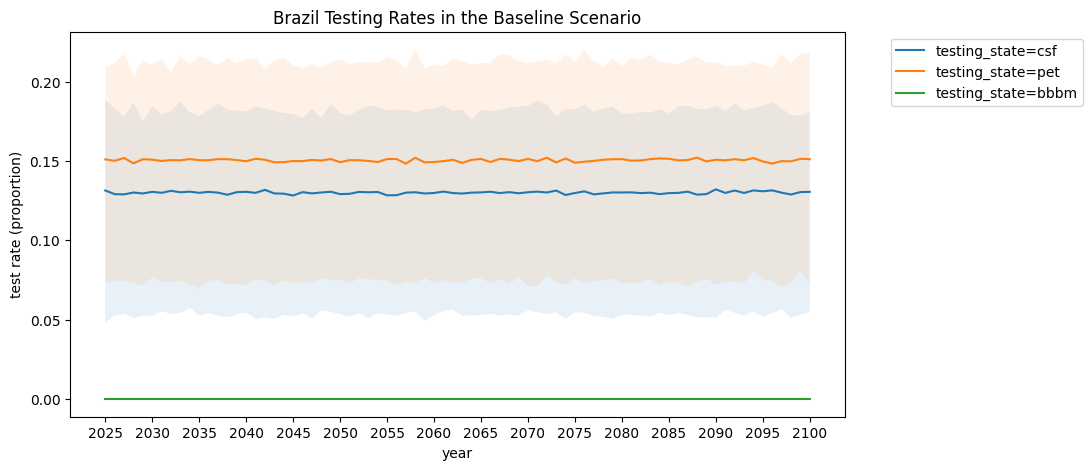

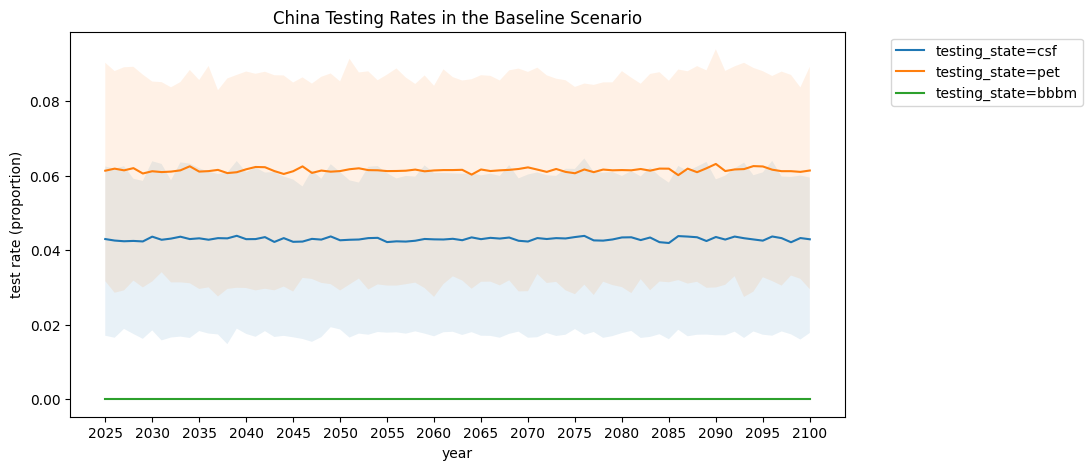

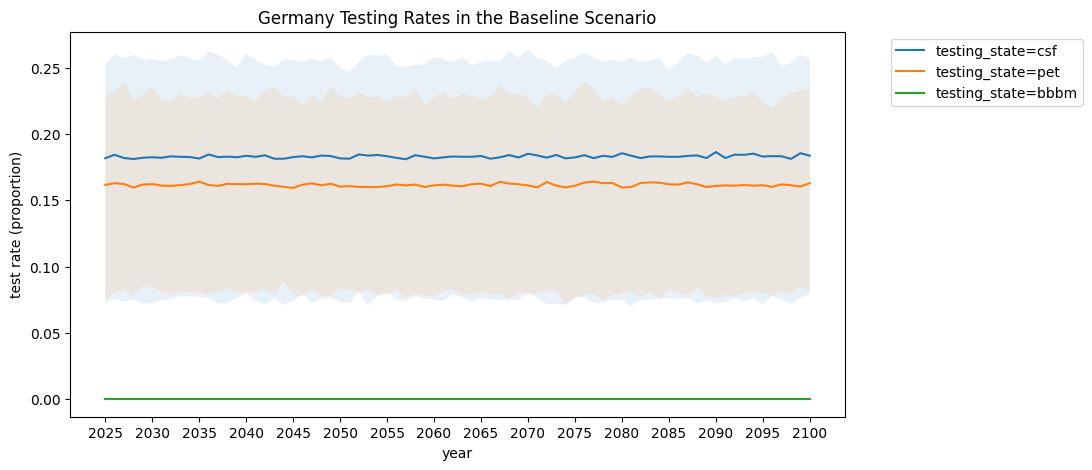

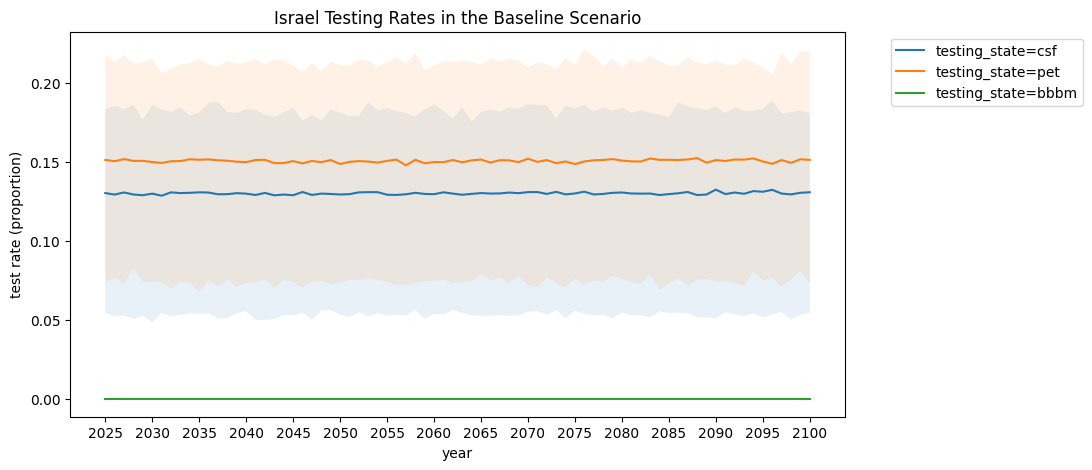

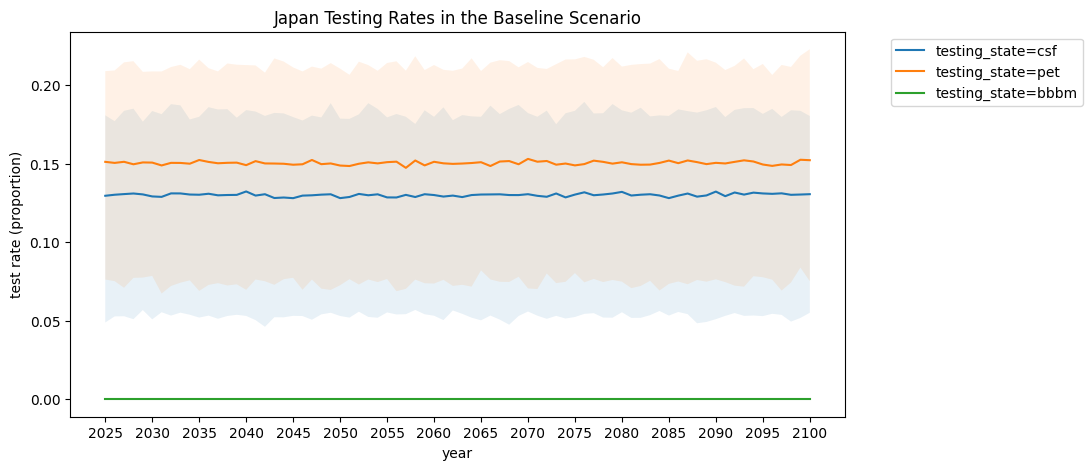

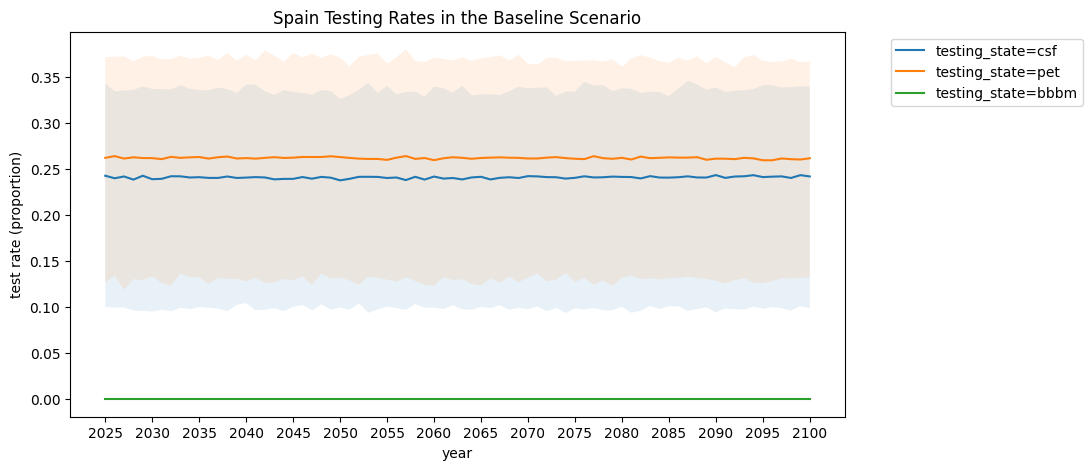

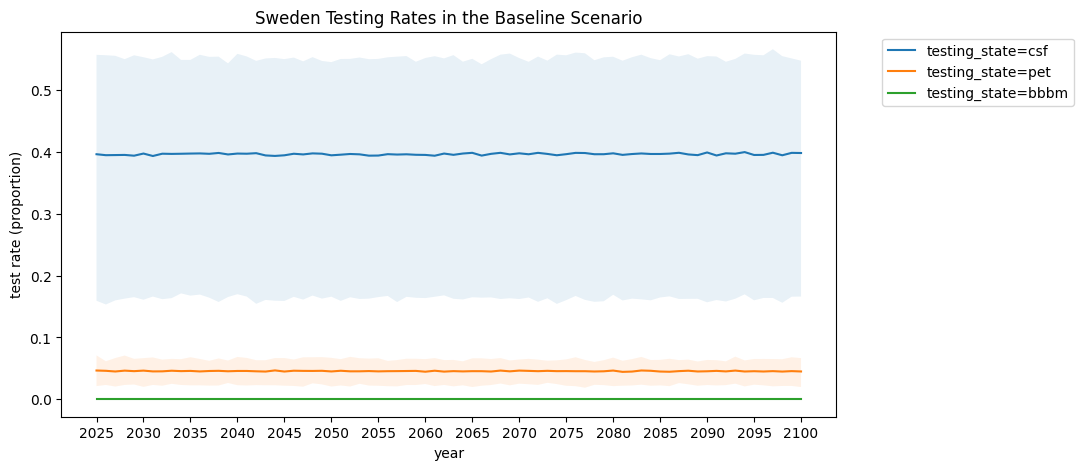

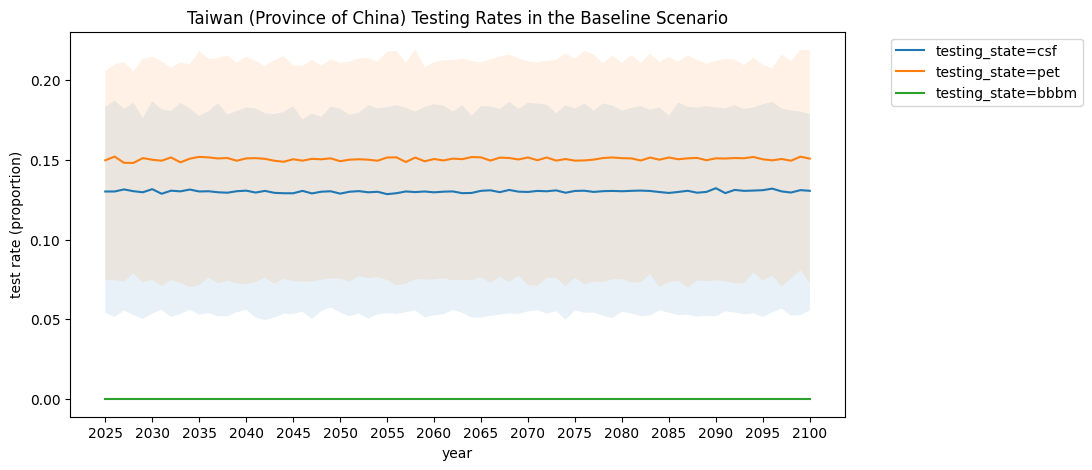

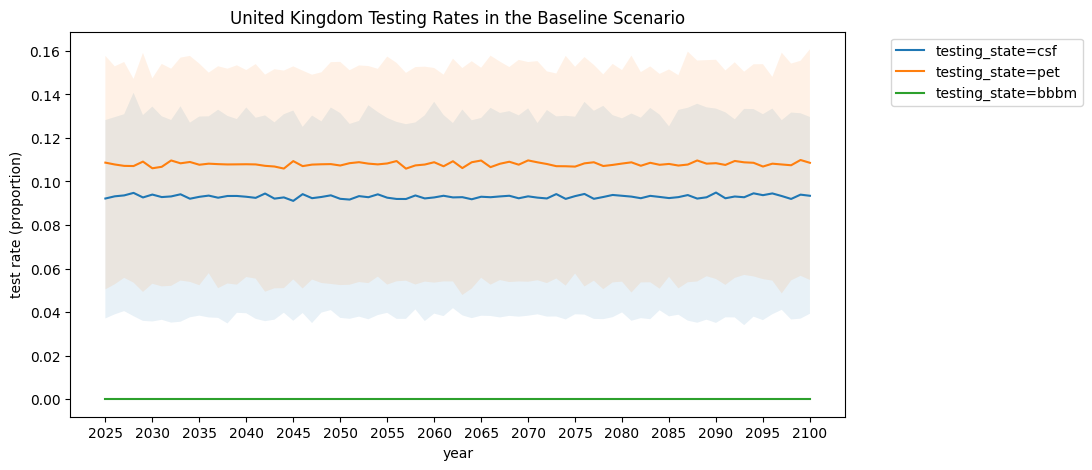

In [26]:
for location in locations:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_over_time_by_column(
        sim_test_rates
        .query("location == @location and scenario == 'baseline' and testing_state != 'not_tested'"),
        'testing_state',
        ylabel='test rate (proportion)',
        title=location + ' Testing Rates in the Baseline Scenario',
    )
    filtered_x_ticks = ax.get_xticks()[::5]
    ax.set_xticks(filtered_x_ticks)

    # artifact_testing_data = summarize_artifact_data(existing_test_rates).query("location==@location")
    # for test_type in artifact_testing_data.index.unique('test_type'):
    #     ax.plot(
    #         filtered_x_ticks,
    #         np.broadcast_to(artifact_testing_data.loc[test_type, 'mean'], (len(filtered_x_ticks),),),
    #         label=f'Artifact {test_type}'
    #     )
    # ax.tick_params(rotation=90)
    # ax.semilogy()
    # ax.set_ylim(0, 0.1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()